#Detect spam


---
Here we consider 2 ways to find spam:

1. using length and punctuation
2. using message text processing


In [4]:
import pandas as pd
#pip install scikit-learn
#import sklearn
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
#import xgboost as xgb

from sklearn import metrics

#**I. Using length and punctuation:**


---




# Data processing

In [2]:
df = pd.read_csv('./smsspamcollection.tsv', sep='\t')
df

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,160,8
5568,ham,Will ü b going to esplanade fr home?,36,1
5569,ham,"Pity, * was in mood for that. So...any other s...",57,7
5570,ham,The guy did some bitching but I acted like i'd...,125,1


In [3]:
df.isnull().sum() #checking the data for NULL

label      0
message    0
length     0
punct      0
dtype: int64

**Defining the target and feature:**

In [4]:
X = df.drop(['label', 'message'], axis=1)
y = df.label
y = y.apply(lambda x: 0 if x == 'ham' else 1)

 **Divide the data into training and test samples**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

**Let's check the quantitative content of SPAM and HAM**

In [6]:
labels = y_train.value_counts()
labels

0    3232
1     501
Name: label, dtype: int64

**We see that they are not equal, which can lead to models being more likely to predict a sample class that is larger.**



---


**To avoid this, we generate additional samples.**



In [7]:
from imblearn.over_sampling import SMOTE

In [8]:
smote = SMOTE(sampling_strategy='minority')
x_smote_over, y_smote_over = smote.fit_resample(X_train, y_train)
y_smote_over.value_counts()

0    3232
1    3232
Name: label, dtype: int64

**It remains to train the model and choose which of the models will be better**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

In [5]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    },
    # 'random_forest': {
    #     'model': RandomForestClassifier(),
    #     'params' : {
    #         'n_estimators': [1,5,10]
    #     }
    # },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    },
    # 'naive_bayes_gaussian': {
    #     'model': GaussianNB(),
    #     'params': {}
    # },
    # 'naive_bayes_multinomial': {
    #     'model': MultinomialNB(),
    #     'params': {}
    # },
    # 'decision_tree': {
    #     'model': DecisionTreeClassifier(),
    #     'params': {
    #         'criterion': ['gini','entropy'],
            
    #     }
    # },
    'XGBClassifier': {
        'model': XGBClassifier(),
        'params' : {
            'alpha': [0], 
            'eta': [0.1], 
            'eval_metric': ['logloss'], 
            'lambda': [1],  
            'max_depth': [5, 10], 
        } 
    },  
}

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
def compare(model_params, x_train, y_train, x_test, y_test):
  scores = []
  for model_name, mp in model_params:
      clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False, scoring='f1-score')
      clf.fit(x_train, y_train)
      scores.append({
          'model': model_name,
          'best_score': clf.best_score_,
          'best_params': clf.best_params_
      })
      predictions=clf.predict(x_test)   
      print(model_name)
      print(metrics.classification_report(y_test,predictions))
  return scores

In [13]:
scores = compare(model_params.items(), x_smote_over, y_smote_over)

In [14]:
Compare_ = pd.DataFrame(scores,columns=['model','best_score_f1','best_params'])
Compare_

,model,best_score,best_params
0,svm,0.884746,"{'C': 10, 'kernel': 'rbf'}"
1,logistic_regression,0.830445,{'C': 1}


# **II. Using message text processing**


---



In [15]:
import spacy
nlp = spacy.load("en_core_web_sm")

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [16]:
# #pip install nltk
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# stopwords = stopwords.words("english")

In [17]:
import re

In [18]:
df

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,160,8
5568,ham,Will ü b going to esplanade fr home?,36,1
5569,ham,"Pity, * was in mood for that. So...any other s...",57,7
5570,ham,The guy did some bitching but I acted like i'd...,125,1


In [19]:
X = df.drop(['label' , 'length', 'punct' ], axis = 1)
X

,message
0,"Go until jurong point, crazy.. Available only ..."
1,Ok lar... Joking wif u oni...
2,Free entry in 2 a wkly comp to win FA Cup fina...
3,U dun say so early hor... U c already then say...
4,"Nah I don't think he goes to usf, he lives aro..."
...,...
5567,This is the 2nd time we have tried 2 contact u...
5568,Will ü b going to esplanade fr home?
5569,"Pity, * was in mood for that. So...any other s..."
5570,The guy did some bitching but I acted like i'd...


In [20]:
type(X)

pandas.core.frame.DataFrame

In [21]:
y = df.label
y = y.apply(lambda x: 0 if x == 'ham' else 1)
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: label, Length: 5572, dtype: int64

**Processing our text in spaCy methods**

In [22]:
X['message'] = X['message'].apply(lambda x: nlp(x))
X

,message
0,"(Go, until, jurong, point, ,, crazy, .., Avail..."
1,"(Ok, lar, ..., Joking, wif, u, oni, ...)"
2,"(Free, entry, in, 2, a, wkly, comp, to, win, F..."
3,"(U, dun, say, so, early, hor, ..., U, c, alrea..."
4,"(Nah, I, do, n't, think, he, goes, to, usf, ,,..."
...,...
5567,"(This, is, the, 2nd, time, we, have, tried, 2,..."
5568,"(Will, ü, b, going, to, esplanade, fr, home, ?)"
5569,"(Pity, ,, *, was, in, mood, for, that, ., So, ..."
5570,"(The, guy, did, some, bitching, but, I, acted,..."


In [23]:
type(X['message'][0])

spacy.tokens.doc.Doc

**Normalizes and eliminates insignificant words**

In [24]:
def normalization_text(x):
    tok = [token.text.lower() for sent in x.sents for token in sent if not (token.is_stop or token.is_punct)]
    tok = ' '.join(tok)
    patern = re.compile(r'[^A-Za-z]')
    tok = re.sub(patern, ' ', tok)
    return tok

In [25]:
X['message'] = X['message'].apply(lambda x: normalization_text(x))

In [26]:
type(X['message'][0])

str

In [27]:
X['message']

0       jurong point crazy available bugis n great wor...
1                                 ok lar joking wif u oni
2       free entry   wkly comp win fa cup final tkts  ...
3                                     u dun early hor u c
4                                nah think goes usf lives
                              ...                        
5567     nd time tried   contact u  u won       pound ...
5568                            b going esplanade fr home
5569                                pity mood suggestions
5570    guy bitching acted like interested buying week...
5571                                            rofl true
Name: message, Length: 5572, dtype: object

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


---
**Сonvert words into vectors**



In [29]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

In [30]:
X_train_counts = count_vect.fit_transform(X_train['message'])
X_train_counts

<3733x6141 sparse matrix of type '<class 'numpy.int64'>'
	with 27611 stored elements in Compressed Sparse Row format>

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()



**Process the train data**

In [32]:
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(3733, 6141)

In [33]:
X_train_tfidf

<3733x6141 sparse matrix of type '<class 'numpy.float64'>'
	with 27611 stored elements in Compressed Sparse Row format>

**Now we process the test data**

In [34]:
X_test_counts = count_vect.transform(X_test['message'])
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [35]:
scores = compare(model_params.items(), X_train_tfidf, y)

In [36]:
Compare_2 = pd.DataFrame(scores,columns=['model','best_score','best_params'])
Compare_2

,model,best_score,best_params
0,svm,0.884746,"{'C': 10, 'kernel': 'rbf'}"
1,logistic_regression,0.830445,{'C': 1}


In [37]:
Compare_

,model,best_score,best_params
0,svm,0.884746,"{'C': 10, 'kernel': 'rbf'}"
1,logistic_regression,0.830445,{'C': 1}


# Not nessesery

---



In [38]:
scores = []

In [39]:
for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(x_smote_over, y_smote_over)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [40]:
Compare = pd.DataFrame(scores,columns=['model','best_score','best_params'])
Compare

,model,best_score,best_params
0,svm,0.884746,"{'C': 10, 'kernel': 'rbf'}"
1,logistic_regression,0.830445,{'C': 1}


In [41]:
xgbModel = XGBClassifier()
xgbpredict = xgbModel.fit(X_train_tfidf, y_train).predict(X_test_tfidf)

print(metrics.confusion_matrix(y_test,xgbpredict))
print(metrics.classification_report(y_test,xgbpredict))

[[1592    1]
 [  63  183]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1593
           1       0.99      0.74      0.85       246

    accuracy                           0.97      1839
   macro avg       0.98      0.87      0.92      1839
weighted avg       0.97      0.97      0.96      1839



In [42]:
X_train_tfidf

<3733x6141 sparse matrix of type '<class 'numpy.float64'>'
	with 27611 stored elements in Compressed Sparse Row format>

In [43]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train_tfidf, y_train)

LinearSVC()

In [44]:
y_pred = clf.predict(X_test_tfidf)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1593
           1       0.99      0.93      0.96       246

    accuracy                           0.99      1839
   macro avg       0.99      0.96      0.97      1839
weighted avg       0.99      0.99      0.99      1839



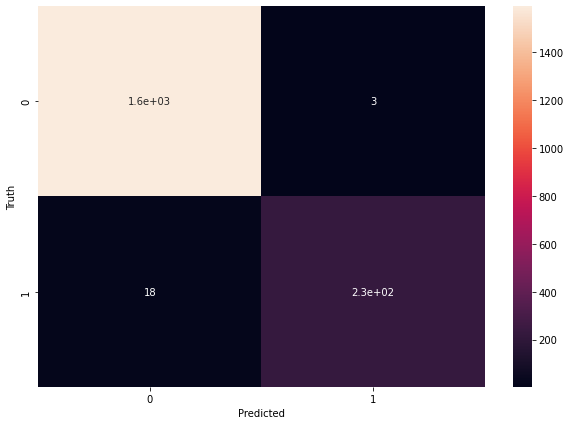

In [45]:
cm = metrics.confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(metrics.classification_report(y_test,y_pred))